In [1]:
from __future__ import division
from utils import *
from functions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)


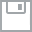
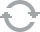
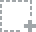
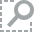
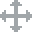
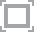
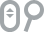
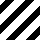
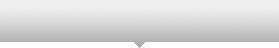
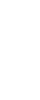
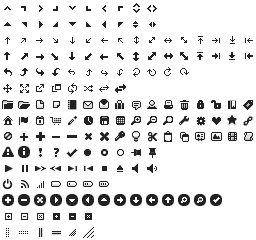
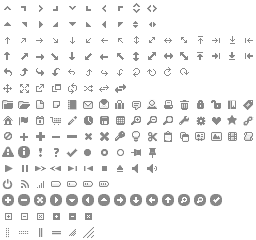
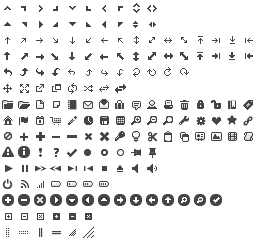
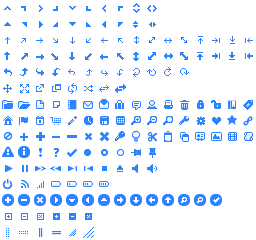
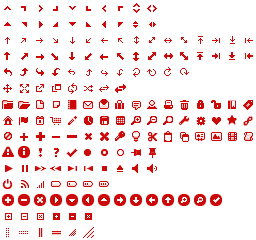
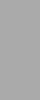
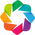
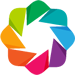

In [2]:
from bokeh.io import output_notebook
output_notebook()

# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH()
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', labelsize = 10)
matplotlib.rc('axes', titlesize = 10)
matplotlib.rc('axes', facecolor = "white")
matplotlib.rc('legend', fontsize = 10)
matplotlib.rc('lines', linewidth=2)

In [3]:
def readPSTH( N, r, G, S, it,
             binsize, d1, d2,
             d3, before, after,
             s, WII, LTP, LTD, model, coeff, RON='izh', tau_m=10):
    gr = GRAPH()
    listSSP1 = Parallel(n_jobs=num_cores)(delayed(cortex.readSimulationSSP1)(N, r,i,G,S,
                                                                           d1, d2, d3, before, after,
                                                                           WII, LTP, LTD, model) for i in range(it))
    if RON == 'izh':
        listS = Parallel(n_jobs=num_cores)(delayed(gr.readoutSpikes)(ssp1, coeff, tau_m) for ssp1 in listSSP1)
    else:
        listS = Parallel(n_jobs=num_cores)(delayed(readoutSpikesIAF)(ssp1, coeff, tau_m) for ssp1 in listSSP1)

    tot = np.sum(listS, axis=0)
    totSSP1 = np.sum(listSSP1, axis=0)
    total = np.sum(listS)
    h = cortex.getHist(tot,binsize)
    hSSP1 = cortex.getHist(totSSP1,binsize)
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, gamma, correlation, ssp1, stimulation,p,q,lowsp,vm = gr.readSimulation(N,r,0,G,S, d1, d2, d3, before, after, WII, LTP, LTD, model)

    return h, stimulation, total, hSSP1

def plotPTSH( fig, before, after,binsize, h, s, it, DIRECTORY, S, N):
    T = before+after
    simsize=T/0.25
    x2 = np.arange(0,(simsize/4-1)/1000, (simsize/len(s)/4)/1000)

    # fig = plt.figure(figsize=(9,5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    # ax0.set_ylim([0,10])
    print(np.arange(0,simsize/1000-binsize/1000,simsize/len(h)/1000).shape)
    print(np.array(h).shape)
    print(binsize/1000)
    ax0.bar(np.arange(0,simsize/1000-binsize/1000,simsize/len(h)/1000),np.array(h)/it, binsize/1000)

    ax0.set_title('PSTH - Input: %s' % S)
    ax0.set_xticks([])

    # plot stimulation s
    ax = plt.subplot(gs[1])
    ax.set_ylim([30,110])
    ax.set_yticks([30,100])
    ax.set_xlabel('Time [s]')
    plt.plot(x2,s)
    plt.tight_layout()
    extension = "_S-%d_N-%d_T-%d" % (S, N, T)
    print(DIRECTORY + extension + '_PTSH.pdf')
    plt.savefig(DIRECTORY + extension + '_PTSH.pdf')
    
def readoutSpikesIAF( ssp1, W, tau_m=10):
    ## setup parameters and state variables
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time

    ## LIF properties
    Vm      = np.zeros(len(time))    # potential (V) trace over time
    Rm      = W                   # resistance (kOhm)
    Cm      = 7                  # capacitance (uF)
    tau_m   = tau_m               # time constant (msec)
    tau_ref = 4                   # refractory period (msec)
    Vth     = 1                   # spike threshold (V)
    V_spike = 0.5                 # spike delta (V)

    ## Stimulus
    I       = ssp1                 # input current (A)

    ## iterate over each time step
    for i, t in enumerate(time):
        if t > t_rest:
            Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm) / tau_m * dt
        if Vm[i] >= Vth:
            Vm[i] += V_spike
            t_rest = t + tau_ref
    # plt.plot(Vm)
    spikes = Vm>1.1
    return spikes

(28,)
(28,)
1.0
/Users/guillaume/Dropbox/0000 - PhD/figures/20160121/_S-180_N-500_T-7100_PTSH.pdf
7.1 1015 0.0069950738916256154


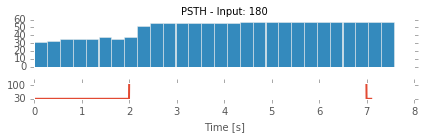

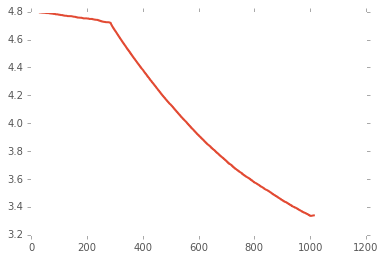

In [33]:
N = 500
G = 4.8
d1 = 2000
d2 = 5000
d3 = 100
before = d1+d2
after = d3
# before = 10000
# after = 40000
S = 100
sigma = 60
WII = 500

FACT = 0.1

ratio = 20
LTD  = 4.7e-6 * FACT * N
LTP = ratio * LTD
r=0.8
model = "gp-izh"

it = 8
binsize=1000
coeff = 1

fig = plt.figure(figsize=(6,2))
# cortex.runPSTH(N=N, r=r, G=G,S=S, it=it,binsize=binsize, d1=d1, d2=d2, d3=d3, before=before, after=after,s=sigma,
#                WII=WII, LTP=LTP, LTD=LTD, model=model)
# h,s,tot, hSSP1 = cortex.readPSTH(N,r, G,S, it,binsize, d1, d2, d3, before, after, s, WII, LTP, LTD, model, coeff, 'IAF')
# gr.plotPTSH(before, after,binsize, h, s, it, DIRECTORY, S, N)
# plt.savefig(DIRECTORY + 'RON.pdf')

# h,s, total,s2 = cortex.readPSTH(N,r, G,S, it,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model, coeff)
# gr.plotPTSH(fig, before, after,binsize, h, s, it, DIRECTORY, S, N)
# #     ints.append(total)
# gr.savePTSH(before, after, h, s, it, DIRECTORY, S, N)
# extension = "_S-%d_N-%d_T-%d" % (S, N, before+after)
# plt.savefig(DIRECTORY + extension + '_PTSH.pdf')


ints = []
for S in range(18,19,2):
    cortex.runPSTH(N=N, r=r, G=G,S=S*10, it=it,binsize=binsize, d1=d1, d2=d2, d3=d3, before=before, after=after,s=sigma,
               WII=WII, LTP=LTP, LTD=LTD, model=model)
for S in range(18,19,2):
    h,s, total,s2, SSP = cortex.readPSTH(N,r, G,S*10, it,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model,coeff,RON='IAF', tau_m = 1)
    plotPTSH(fig, before, after,binsize, h, s, it, DIRECTORY, S*10, N)
#     ints.append(total)
    gr.savePTSH(before, after, h, s, it, DIRECTORY, S*10, N)
    extension = "_S-%d_N-%d_T-%d" % (S, N, before+after)
#     plt.savefig(DIRECTORY + extension + '_PTSH.pdf')
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc,\
    gamma, correlation, ssp1, stimulation,\
    p,q,lowsp,vm = cortex.readSimulation(N, r, 0, G, S*10, d1, d2, d3, before, after, WII, LTP, LTD, model, )
    plt.figure()
    plt.plot(gamma)
#     plt.save(DIRECTORY + 'gammaPTSH-S%d.pdf'%(S*10))

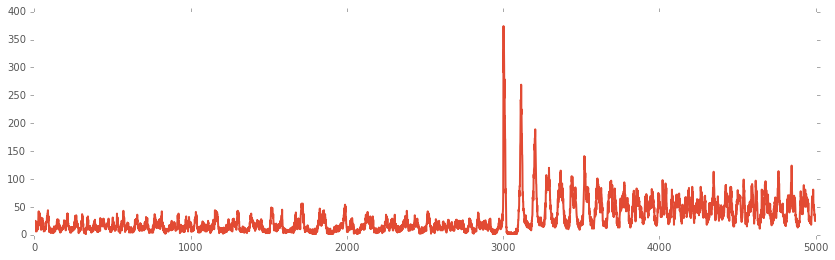

In [34]:
fig = plt.figure(figsize=(14,4))
plt.plot(SSP[5000:10000])

In [35]:
start = findIndex2(spikes_x,1000)
end = findIndex2(spikes_x,6000)
gr.plotRasterGPU(spikes_x[start:end],spikes_y[start:end], "")

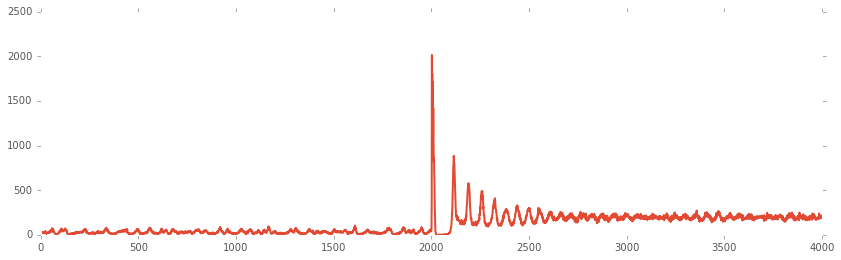

In [37]:
fig = plt.figure(figsize=(14,4))
plt.plot(SSP[78000:82000])

In [6]:
SSP = np.zeros(240000)
for it in range(8):
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc,\
#         gamma, correlation, ssp1, stimulation,\
        p,q,lowsp,vm = cortex.readSimulation(N, r, 1, G, S*10, d1, d2, d3, before, after, WII, LTP, LTD, model, )
    SSP += ssp1


In [17]:
# plt.plot(SSP)

In [13]:
def readoutSpikesIAF( ssp1, W, sigma, tau_m=10):
    ## setup parameters and state variables
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time

    ## LIF properties
    Vm      = np.zeros(len(time))    # potential (V) trace over time
    spikes  = np.zeros(len(time))
    np.random.seed(None) # for joblib otherwise, take the same RandomState
    Rm      = W*np.random.lognormal(3, sigma )                 # resistance (kOhm)
    Cm      = 7                  # capacitance (uF)
    tau_m   = tau_m               # time constant (msec)
    tau_ref = 4                   # refractory period (msec)
    Vth     = 1                   # spike threshold (V)
    V_spike = 0.5                 # spike delta (V)

    ## Stimulus
    I       = ssp1                 # input current (A)     
    ## iterate over each time step
    for i, t in enumerate(time):
        if t > t_rest:
            Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm) / tau_m * dt
        if Vm[i] >= Vth:
            Vm[i] += V_spike
            t_rest = t + tau_ref
    # plt.plot(Vm)
    spikes = Vm>1.4
        
    return spikes

In [111]:
# RON = readoutSpikesIAF(ssp1, 10, tau_m=40)

In [112]:
# plt.plot(RON[0:10000])

In [10]:
def ron_net(ssp1, W, var, N,  tau_m=10):
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25                # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    spikes  = np.zeros(len(time))

    sp = Parallel(n_jobs=num_cores)(delayed(readoutSpikesIAF)(ssp1, W, var,tau_m) for k in range(N))

    spikes = np.sum(sp,axis=0)
    print(spikes.shape)
    return spikes
        

(240000,)


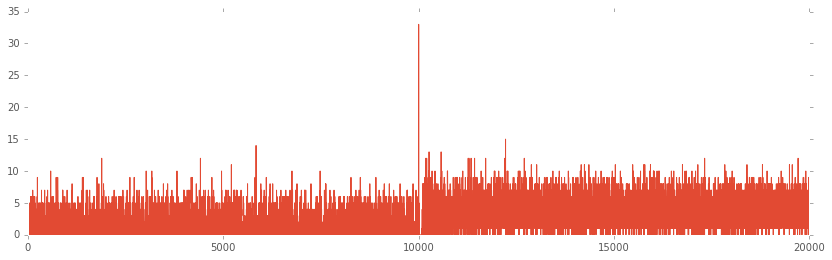

In [43]:
plt.figure(figsize=(14,4))
RON = ron_net(SSP, 0.01, 1, 80, 40)
plt.plot(RON[70000:90000], linewidth=1)

0.008601324513508956


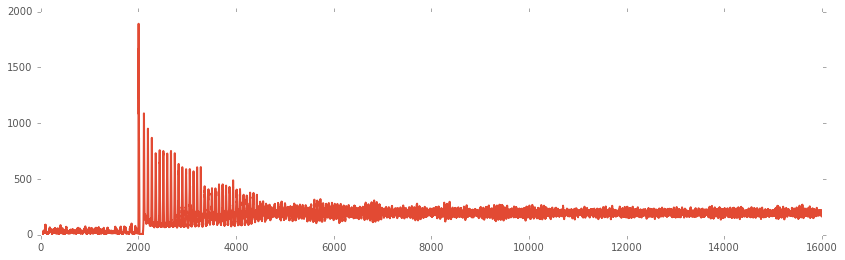

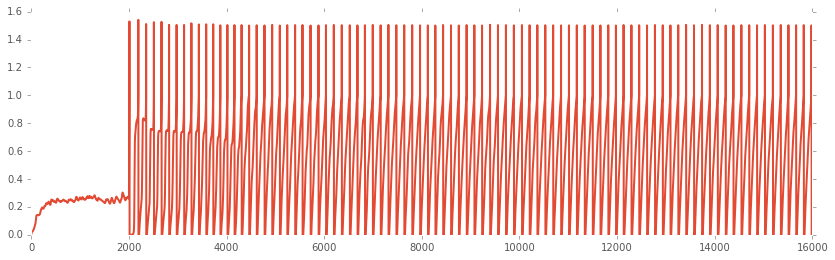

In [63]:
plt.figure(figsize=(14,4))
plt.plot(SSP[78000:94000])
plt.figure(figsize=(14,4))
plotIAF(SSP[78000:94000], 0.0005,1, 40)

In [11]:
def findIndex2(spikes_x,val):
    res = (spikes_x-val).argmin()
    return res

findIndex2(spikes_x,4000)

31862

In [12]:
def plotIAF( ssp1, W,sigma, tau_m=40):
    ## setup parameters and state variables
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time

    ## LIF properties
    Vm      = np.zeros(len(time))    # potential (V) trace over time
    spikes  = np.zeros(len(time))
    Rm      = W*np.random.lognormal(3, sigma )                  # resistance (kOhm)
    Cm      = 7                  # capacitance (uF)
    tau_m   = tau_m               # time constant (msec)
    tau_ref = 4                   # refractory period (msec)
    Vth     = 1                   # spike threshold (V)
    V_spike = 0.5                 # spike delta (V)
    print(Rm)
    ## Stimulus
    I       = ssp1                 # input current (A)     
    ## iterate over each time step
    for i, t in enumerate(time):
        if t > t_rest:
            Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm) / tau_m * dt
        if Vm[i] >= Vth:
            Vm[i] += V_spike
            t_rest = t + tau_ref
    plt.plot(Vm)
#     spikes = Vm>1.1

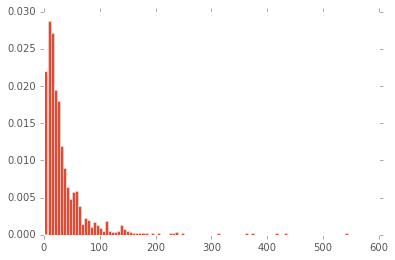

In [59]:
# plt.histnp.random.lognormal(3,1,10000))
count, bins, ignored = plt.hist(np.random.lognormal(3,1,1000), 100, normed=True, align='mid')